In [193]:
import warnings
warnings.filterwarnings("ignore")

import os
import joblib
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime as dt
from tqdm import tqdm
import random
from scipy.sparse import save_npz, load_npz

from IPython.display import Image
from wordcloud import WordCloud
from sqlalchemy import create_engine # Database connection
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from datetime import datetime

Data:

Subsampling to reduce data size: 500k posts

In [122]:
data_dir = "G:/work/Carleton/Fall 2022/COMP 5505 O - NLP/Final Project/Data/"
raw = "raw/"


start = datetime.now()
disk_engine = create_engine("sqlite:///train_sub.db")

num_chuncks = 0

with tqdm(total=5*1e5, desc="Loaded:") as pbar:
    start = dt.datetime.now()
    chunksize = 100000
    index_start = 1
    num_chunks = 0
    for df in pd.read_csv(data_dir + raw + "Train.zip", names=["Id", "Title", "Body", "Tags"], chunksize=chunksize, iterator=True, encoding="utf-8"):
        if num_chunks >= 5:
            break
        df.index += index_start
        df.to_sql("data", disk_engine, if_exists = 'append')
        index_start = df.index[-1] + 1
        pbar.update(1e5)
        num_chunks += 1
    print("Time taken to run this cell: ", datetime.now() - start)

Loaded:: 100%|██████████████████████████████████████████████████████████| 500000.0/500000.0 [00:32<00:00, 15504.60it/s]

Time taken to run this cell:  0:00:32.248484


In [123]:
start = datetime.now()
con = sqlite3.connect("train_sub.db")
num_rows = pd.read_sql_query("SELECT count(*) FROM data", con)
print("Number of rows in the database: \n", num_rows["count(*)"].values[0])
con.close()
print("Time taken to count the number of rows: ", datetime.now() - start)

Number of rows in the database: 
 500000
Time taken to count the number of rows:  0:00:00.033592


In [124]:
start = datetime.now()
con = sqlite3.connect("train_sub.db")
df_no_dup = pd.read_sql_query("SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags", con)
con.close()
print("Time taken to run this cell: ", datetime.now() - start)

Time taken to run this cell:  0:00:07.935724


In [125]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus,1
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1
3,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc,1
4,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,2


In [127]:
print(np.sum(df_no_dup['cnt_dup']))        # Total Number of Questions
print(num_rows['count(*)'].values[0])      # Total Number of Questions
print(df_no_dup.shape[0])                  # Total Number of unique questions

500000
500000
485836


In [128]:
print("Number of duplicate questions: ", num_rows['count(*)'].values[0] - df_no_dup.shape[0],  "(",(1 - ((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

Number of duplicate questions:  14164 ( 2.832800000000002 % )


In [129]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")) if text != None else 0)

# Adding a new feature number of tags per question
print("Time taken to run this cell: ", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell:  0:00:00.283248


,Title,Body,Tags,cnt_dup,tag_count
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1,2
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus,1,1
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1,3
3,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc,1,1
4,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,2,2


In [130]:
disk_dup = create_engine("sqlite:///train_sub_no_dup.db")
no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
no_dup.to_sql('no_dup_train', disk_dup)

In [132]:
start = datetime.now()
con = sqlite3.connect("train_sub_no_dup.db")
tag_data = pd.read_sql_query("SELECT Tags FROM no_dup_train", con)
con.close()

tag_data.drop(tag_data.index[0], inplace = True)
tag_data.head()
print("Time taken to run this cell: ", datetime.now() - start)

Time taken to run this cell:  0:00:01.234124


In [136]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())

tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [137]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 485835
Number of unique tags : 30429


In [138]:
tags = vectorizer.get_feature_names()

print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.doc', '.each', '.emf', '.exe', '.hgtags']


In [139]:
freqs = tag_dtm.sum(axis = 0).A1
result = dict(zip(tags, freqs))

In [140]:
with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in result.items():
        writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,3
1,.app,8
2,.aspxauth,3
3,.bash-profile,13
4,.class-file,5


In [141]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

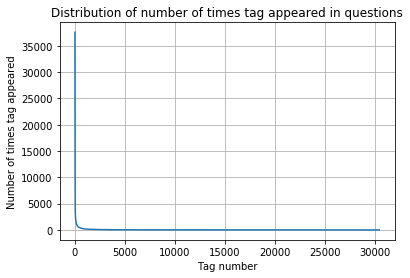

In [142]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

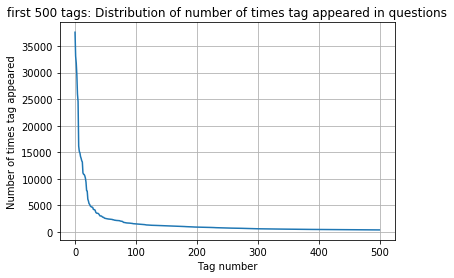

100 [37603 24567 13873 10826  7706  4909  4279  3585  3221  2827  2566  2442
  2376  2222  2176  2052  1801  1708  1670  1576  1529  1480  1429  1370
  1315  1279  1257  1234  1215  1199  1178  1138  1109  1092  1072  1055
  1030   998   981   949   924   910   900   881   865   854   822   802
   790   769   747   739   725   716   701   686   664   646   636   620
   612   602   594   591   577   573   562   555   548   541   539   534
   525   514   506   502   496   494   487   484   479   475   470   462
   457   453   447   447   441   438   434   429   427   421   419   416
   407   404   402   400]


In [143]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared in questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

Preprocessing texts

- Sample 500k data points
- Separate out code-snippets from Body
- Remove special characters from Question title and description (not in code)
- Remove stop words (Except 'C')
- Remove HTML Tags
- Convert all the characters into small letters


In [146]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

stop_words = set(stopwords.words('english'))

In [147]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables = table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()


sql_create_table = "CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [148]:
start = datetime.now()
read_db = "train_sub_no_dup.db"
write_db = "Processed.db"

if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared all the rows")

print("Time taken to run this cell: ", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared all the rows
Time taken to run this cell:  0:00:00.003001


In [151]:
start = datetime.now()
preprocessed_data_list = []
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_processed = 0

for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], row[2]

    if "<code>" in question:
        questions_with_code += 1
        is_code = 1
    x = len(question) + len(title)
    len_pre += x

    code = str(re.findall(r"<code>(.*?)</code>", question, flags=re.DOTALL))
    question = re.sub("<code>(.*?)</code>", "", question, flags=re.MULTILINE|re.DOTALL)
    question = striphtml(question.encode("utf-8"))
    title = title.encode("utf-8")

    question = str(title) + " " + str(question)
    question = re.sub(r"[^A-Za-z]+"," ",question)
    words = word_tokenize(str(question.lower()))

    question=' '.join(str(j) for j in words if j not in stop_words and (len(j) != 1 or j == "c"))

    len_post += len(question)
    tup = (question, code, tags, x, len(question), is_code)
    questions_processed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_processed % 100000 == 0):
        print("Number of questions completed = ",questions_processed)

no_dup_avg_len_pre = (len_pre*1.0) / questions_processed
no_dup_avg_len_post = (len_post*1.0) / questions_processed

print("Avg length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print("Avg length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_processed))
print("Time taken to run this cell :", datetime.now() - start)

Number of questions completed =  100000
Number of questions completed =  200000
Number of questions completed =  300000
Number of questions completed =  400000
Avg length of questions(Title+Body) before processing: 1150
Avg length of questions(Title+Body) after processing: 370
Percent of questions containing code: 56
Time taken to run this cell : 0:03:51.810306


In [152]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [153]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('accessing local session bean exposed resteasy interface trying straight forward thus far impossible someone tell access local session bean exposed resteasy interface trawled length breadth internet find variations example trying find access session bean normal way using resteasy things look like far using ejb resteasy published ejb interface bean unpublished ejb interface bean example super simplified purposes demonstrating issue thanks advance help',)
----------------------------------------------------------------------------------------------------
('argument page griffith book introduction algebraic curves bit confused things griffiths says page book introduction algebraic curves sure reproduce text see googlebooks pages display firstly felt points nu points algebraic curve non trivial topology way line lambda set omega talked seems one working mathbb c times mathbb c right picture local analytic elements generically non trivial riemann surface mathbb

In [154]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [155]:
preprocessed_data.head()

,question,tags
0,internal server error asp net mvc working asp ...,asp.net-mvc
1,accessing local session bean exposed resteasy ...,ejb resteasy
2,argument page griffith book introduction algeb...,algebraic-geometry complex-analysis riemann-su...
3,automatic data recognition plot processing pgf...,pgfplots
4,code working find duplicate values using jquer...,spservices


In [156]:
print("Number of data points in sample:", preprocessed_data.shape[0])
print("Number of dimensions:", preprocessed_data.shape[1])

Number of data points in sample: 485833
Number of dimensions: 2


In [157]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [159]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [160]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

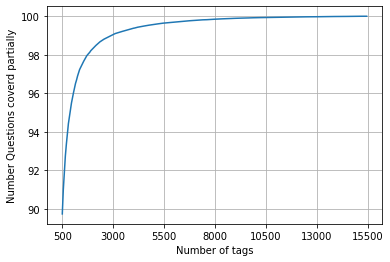

With  500 tags we are covering  89.747 % of questions


In [166]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500 + np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

print("With ", 500, "tags we are covering ", questions_explained[0], "% of questions")

In [169]:
multilabel_yx = tags_to_choose(500)
print("Number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

Number of questions that are not covered : 49812 out of  485833


In [170]:
print("Number of tags in sample:", multilabel_y.shape[1])
print("Number of tags taken:", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample: 30429
Number of tags taken: 500 ( 1.6431693450326992 %)


In [177]:
total_size = preprocessed_data.shape[0]
train_size = int(0.80*total_size)

x_train = preprocessed_data.head(train_size)
x_test = preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size, : ]
y_test = multilabel_yx[train_size:total_size, : ]

In [205]:
x_train.to_csv("x_train_final.csv", index=False)
x_test.to_csv("x_test_final.csv", index=False)

save_npz("y_train_final", y_train, compressed=True)
save_npz("y_test_final", y_test, compressed=True)